# CARGA DE LIBRERIAS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy

import torch
from torch import nn  # Modelos neuronales y funciones de Loss

from torch import optim # (3er paso BACKPROPAGATION) Optimizadores ---> Gradiente descendiente, Adam, AdaDelta, etc
from torch.utils.data import Dataset, DataLoader

import sys

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # Elige el dispositivo. Utilizará GPU si está disponible

sys.path.append('/home/sebacastillo/neuralnets/')
from src.utils import get_project_root
root = get_project_root()

In [2]:
dir = str(root) + '/course_bib/Ejercicio2_resuelto/'

In [3]:
data = pd.read_csv( dir + 'irisbin.csv', header=None).to_numpy()

# RBF NN

In [4]:
class RBFNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_centers, sigma):
        super(RBFNet, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_centers = num_centers
        
        self.centers = nn.Parameter(torch.randn(num_centers, input_dim))
        self.beta = nn.Parameter(torch.ones(num_centers, 1) / num_centers)
        self.sigma = sigma
        
        self.fc = nn.Linear(num_centers, output_dim)
    
    def radial_basis(self, x):
        C = self.centers.view(self.num_centers, -1)
        x = x.unsqueeze(1).expand(-1, self.num_centers, -1)
        return torch.exp(-torch.sum((x - C) ** 2, dim=2) / (2 * self.sigma ** 2))
    
    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, -1)
        H = self.radial_basis(x)
        out = self.fc(H)
        return out

Radil Basis Function

1. `C = self.centers.view(self.num_centers, -1)`: This reshapes the centers of the radial basis functions (RBFs), stored in `self.centers`, into a 2D tensor with shape `(num_centers, -1)`. The `-1` is a placeholder that means "infer the size of this dimension from the data". In this case, it corresponds to the dimension of the input space (i.e., the number of features in the input data).

2. `x = x.unsqueeze(1).expand(-1, self.num_centers, -1)`: This line is doing two things. First, `unsqueeze(1)` adds an extra dimension to the input data tensor `x`, changing its shape from `(batch_size, input_dim)` to `(batch_size, 1, input_dim)`. This extra dimension is needed so that `x` and `C` have the same number of dimensions and can be subtracted from each other in the next line. Then, `expand(-1, self.num_centers, -1)` replicates the input data along the new dimension to match the number of centers. The `-1`s here are placeholders that mean "keep the size of this dimension the same as in the original data".

3. `return torch.exp(-torch.sum((x - C) ** 2, dim=2) / (2 * self.sigma ** 2))`: This is the computation of the RBF. The expression `(x - C) ** 2` calculates the squared Euclidean distance between each data point and each center. `torch.sum(..., dim=2)` sums these squared distances over the input dimensions to get the total squared distance for each data point and each center. This result is divided by `2 * self.sigma ** 2`, and the negative of this is passed through the exponential function `torch.exp()` to get the output of the RBF.

So, the output of this function is a tensor `H` with shape `(batch_size, num_centers)`, where `H[i, j]` is the output of the `j`-th RBF for the `i`-th data point. This tensor `H` is then passed through the linear layer in the `forward` method to get the final output of the network.

In [5]:
class DATASET(Dataset):  # <----------------
    '''
    Esta clase maneja la lectura de los datos y provee un mecanismo
    para alimentar los modelos con los patrones.
    '''
    
    #===================================================
    def __init__(self, filename):
        
        #------------------------------------
        # LECTURA DE LOS DATOS
        data = pd.read_csv(filename, header=0) # Levanta los datos en formato numpy
        
        #------------------------------------
        # TRANSFORMO A DATOS DE NUMPY
        data = data.to_numpy()
        
        #------------------------------------
        # ALEATORIZO LOS PATRONES (filas)
        idxs = np.arange(len(data))  # Genero un vector de índices
        np.random.shuffle(idxs)
        data = data[idxs,:]
        
        #------------------------------------
        # SEPARO LOS DATOS
        self.x = data[:,:-1].astype(np.float32)
        self.y = data[:,-1].astype(np.longlong)  # La clase está en la última columna
        
    
    #===================================================
    def __len__(self):
        '''
        Devuelve el número de patrones en el dataset.
        '''
        return len(self.x)
    
    
    #===================================================
    def __getitem__(self, idx):
        '''
        Devuelve el/los patrones indicados.
        '''
        return self.x[idx,:], self.y[idx]

In [6]:
BATCH_SIZE=32
filename_train = dir + 'data_trn.csv'
filename_test = dir + 'data_tst.csv'

trn = DATASET(filename_train)
tst = DATASET(filename_test)

train_loader = DataLoader(trn, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(tst, batch_size=BATCH_SIZE, shuffle=False)

In [7]:
# dataloaders
input_dim = 4
hidden_dim = 10
output_dim = 3
num_centers = 10
sigma = 1.0
model = RBFNet(input_dim, hidden_dim, output_dim, num_centers, sigma)

# loss function and an optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# epochs
epochs = 140

# Evaluation objects
train_losses = []
test_losses = []
test_accuracies = []

# Training loop
for epoch in range(epochs):
    train_loss = 0.0
    test_loss = 0.0
    correct = 0.0
    model.train() 
    for inputs, labels in train_loader:
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward() 
        optimizer.step() 
        train_loss += loss.item() * inputs.size(0)
        
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            # calculate accuracy
            _, pred = torch.max(outputs, dim=1)
            correct += pred.eq(labels).sum().item()    
   
    train_loss = train_loss / len(train_loader.dataset)
    test_loss = test_loss / len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)

    # append losses and accuracy
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)

    if (epoch % 20) == 0:
        print(f'Epoch: {epoch+1} \tTraining Loss: {train_loss:.6f} \tTest Loss: {test_loss:.6f} \tTest Accuracy: {accuracy:.6f}')


Epoch: 1 	Training Loss: 1.084044 	Test Loss: 1.117687 	Test Accuracy: 0.379310
Epoch: 21 	Training Loss: 1.082786 	Test Loss: 1.115271 	Test Accuracy: 0.379310
Epoch: 41 	Training Loss: 1.048461 	Test Loss: 1.060869 	Test Accuracy: 0.379310
Epoch: 61 	Training Loss: 0.679063 	Test Loss: 0.717566 	Test Accuracy: 0.655172
Epoch: 81 	Training Loss: 0.494328 	Test Loss: 0.533248 	Test Accuracy: 0.655172
Epoch: 101 	Training Loss: 0.422399 	Test Loss: 0.442416 	Test Accuracy: 0.862069
Epoch: 121 	Training Loss: 0.241603 	Test Loss: 0.226353 	Test Accuracy: 1.000000


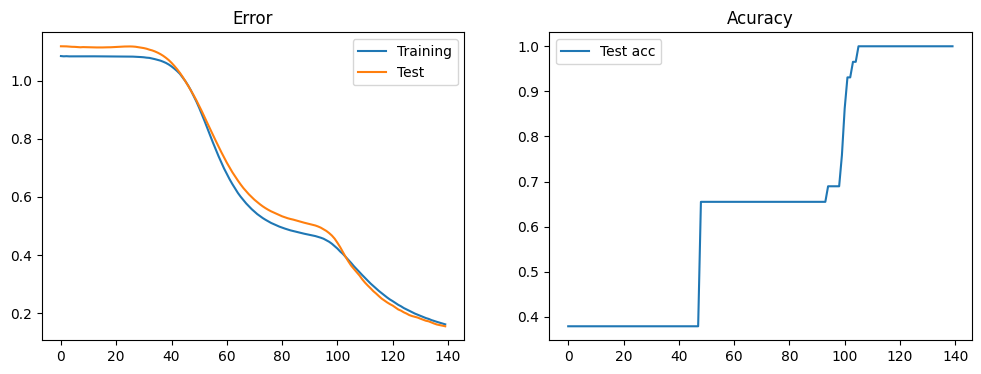

In [8]:
# plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training')
plt.plot(test_losses, label='Test')
plt.legend()
plt.title('Error')

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test acc')
plt.legend()
plt.title('Acuracy')

plt.show()